In [1]:
from pathlib import Path
import json
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Error Analysis

## Data Preparation

In [2]:
root_path = Path("results")

In [3]:
models = [m for m in root_path.iterdir() if m.is_dir()]

In [4]:
summary = {}

In [5]:
for model in tqdm(models):
    tasks = [t for t in model.iterdir() if t.is_dir()]
    if summary.get(model.name) is None:
        summary[model.name] = {}
    for task in tqdm(tasks):
        if summary[model.name].get(task.name) is None:
            summary[model.name][task.name] = {}
        prompt_engineering = [p for p in task.iterdir() if p.is_dir()]
        for prompt in tqdm(prompt_engineering):
            if summary[model.name][task.name].get(prompt.name) is None:
                summary[model.name][task.name][prompt.name] = {}
            prompt_name = prompt.name
            outputs = [f for f in prompt.iterdir() if f.is_file() and f.suffix == ".json"]
            for output in tqdm(outputs):
                with open(output, "r") as f:
                    data = json.load(f)
                    if summary[model.name][task.name][prompt_name].get("total") is None:
                        summary[model.name][task.name][prompt_name]["total"] = 0
                    if summary[model.name][task.name][prompt_name].get("correct") is None:
                        summary[model.name][task.name][prompt_name]["correct"] = 0
                    if summary[model.name][task.name][prompt_name].get("incorrect") is None:
                        summary[model.name][task.name][prompt_name]["incorrect"] = 0

                    if not data.get("is_correct"):
                        if summary[model.name][task.name][prompt_name].get("incorrect_files") is None:
                            summary[model.name][task.name][prompt_name]["incorrect_files"] = []
                        summary[model.name][task.name][prompt_name]["incorrect_files"].append(output)
                        summary[model.name][task.name][prompt_name]["incorrect"] += 1
                    else:
                        summary[model.name][task.name][prompt_name]["correct"] += 1
                    summary[model.name][task.name][prompt_name]["total"] += 1

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]


  0%|          | 0/1201 [00:00<?, ?it/s]


100%|██████████| 1201/1201 [00:00<00:00, 8579.44it/s][A


 25%|██▌       | 1/4 [00:00<00:00,  6.17it/s]


  0%|          | 0/1201 [00:00<?, ?it/s]


100%|██████████| 1201/1201 [00:00<00:00, 9109.41it/s][A


 50%|█████     | 2/4 [00:00<00:00,  6.36it/s]


  0%|          | 0/1201 [00:00<?, ?it/s]


100%|██████████| 1201/1201 [00:00<00:00, 9179.86it/s][A


 75%|███████▌  | 3/4 [00:00<00:00,  6.46it/s]


  0%|          | 0/1201 [00:00<?, ?it/s]


100%|██████████| 1201/1201 [00:00<00:00, 9331.85it/s][A


100%|██████████| 4/4 [00:00<00:00,  6.48it/s]

 12%|█▎        | 1/8 [00:00<00:04,  1.61it/s]

  0%|          | 0/4 [00:00<?, ?it/s]


  0%|          | 0/1001 [00:00<?, ?it/s]


100%|██████████| 1001/1001 [00:00<00:00, 9311.99it/s][A


 25%|██▌       | 1/4 [00:00<00:00,  8.04it/s]


  0%|          | 0/1001 [00:00<?, ?it/s]


100%|██████████| 1001/1001 [00:00<00:00, 9054.6

In [6]:
summary_str = {}
for model in summary:
    summary_str[model] = {}
    for task in summary[model]:
        summary_str[model][task] = {}
        for prompt in summary[model][task]:
            summary_str[model][task][prompt] = {}
            for key in summary[model][task][prompt]:
                if isinstance(summary[model][task][prompt][key], list):
                    summary_str[model][task][prompt][key] = [str(p) for p in summary[model][task][prompt][key]]
                else:
                    summary_str[model][task][prompt][key] = summary[model][task][prompt][key]

In [7]:
with open("error_summary.json", "w") as f:
    json.dump(summary_str, f, indent=4)

## Categorize the errors

In [8]:
with open("error_summary.json", "r") as f:
    error_summary = json.load(f)

In [9]:
for model in error_summary:
    for task in error_summary[model]:
        for prompt in error_summary[model][task]:
            if error_summary[model][task][prompt].get("incorrect_files") is not None:
                error_summary[model][task][prompt]["incorrect_files"] = [Path(p) for p in
                                                                         error_summary[model][task][prompt][
                                                                             "incorrect_files"]]

In [10]:
error_categories = {}

Three error categories:
1. Empty response: The model did not return any response.
2. Incorrect response: The model returned a response but it was incorrect.
3. Error response: The model returned an error message.

In [11]:
for model in tqdm(error_summary):
    # if model in ["llama-2-7b", "llama-2-chat-7b"]:  # Skip ablation studies
    #     continue

    if error_categories.get(model) is None:
        error_categories[model] = {}
    for task in tqdm(error_summary[model]):
        if error_categories[model].get(task) is None:
            error_categories[model][task] = {}
        for pe in tqdm(error_summary[model][task]):
            if pe in ["null-shot-after", "null-shot-v1", "null-shot-v2", "null-shot-v3"]:  # Skip ablation studies
                continue

            if error_categories[model][task].get(pe) is None:
                error_categories[model][task][pe] = {}

            if error_summary[model][task][pe].get("incorrect_files") is not None:
                error_categories[model][task][pe]["empty_response"] = []
                error_categories[model][task][pe]["incorrect_response"] = []
                error_categories[model][task][pe]["error_response"] = []
                error_categories[model][task][pe]["total"] = error_summary[model][task][pe]["total"]
                error_categories[model][task][pe]["correct"] = error_summary[model][task][pe]["correct"]

                for file in tqdm(error_summary[model][task][pe]["incorrect_files"]):
                    with open(file, "r") as f:
                        data = json.load(f)
                        if data.get("response") is None:
                            continue
                        elif data.get("response") == "":
                            error_categories[model][task][pe]["empty_response"].append(file)
                        elif not data.get("is_correct"):
                            error_categories[model][task][pe]["incorrect_response"].append(file)
                        elif "ERROR:" in data.get("response"):
                            error_categories[model][task][pe]["error_response"].append(file)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]


100%|██████████| 588/588 [00:00<00:00, 7080.92it/s]



100%|██████████| 661/661 [00:00<00:00, 7918.19it/s]


 50%|█████     | 2/4 [00:00<00:00, 11.84it/s]


100%|██████████| 614/614 [00:00<00:00, 7699.08it/s]



100%|██████████| 578/578 [00:00<00:00, 7582.50it/s]


100%|██████████| 4/4 [00:00<00:00, 12.19it/s]

 12%|█▎        | 1/8 [00:00<00:02,  3.04it/s]

  0%|          | 0/4 [00:00<?, ?it/s]


100%|██████████| 296/296 [00:00<00:00, 7026.55it/s]



  0%|          | 0/992 [00:00<?, ?it/s]


100%|██████████| 992/992 [00:00<00:00, 8170.48it/s]


 50%|█████     | 2/4 [00:00<00:00, 12.09it/s]


100%|██████████| 381/381 [00:00<00:00, 7933.54it/s]



100%|██████████| 747/747 [00:00<00:00, 8265.91it/s]


100%|██████████| 4/4 [00:00<00:00, 13.03it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.16it/s]

  0%|          | 0/4 [00:00<?, ?it/s]


100%|██████████| 222/222 [00:00<00:00, 5521.83it/s]



100%|██████████| 258/258

In [12]:
summarized_error_categories = {}
for model in error_categories:
    summarized_error_categories[model] = {}
    for task in error_categories[model]:
        summarized_error_categories[model][task] = {}
        for pe in error_categories[model][task]:
            summarized_error_categories[model][task][pe] = {
                "total": error_categories[model][task][pe]["total"],
                "correct": error_categories[model][task][pe]["correct"],
            }
            for category in error_categories[model][task][pe]:
                if category in ["total", "correct"]:
                    continue
                summarized_error_categories[model][task][pe][category] = len(
                    error_categories[model][task][pe][category])

Are there any pairs that has non-zero error?

In [13]:
count = 0
for model in summarized_error_categories:
    for task in summarized_error_categories[model]:
        for pe in summarized_error_categories[model][task]:
            if summarized_error_categories[model][task][pe]["error_response"] != 0:
                count += 1
                
print(count)

0


What is the average `empty_response` rate for each pair?

In [14]:
temp = []
for model in summarized_error_categories:
    for task in summarized_error_categories[model]:
        for pe in summarized_error_categories[model][task]:
            temp.append({
                "model": model,
                "task": task,
                "pe": pe,
                "empty_response": summarized_error_categories[model][task][pe]["empty_response"] /
                                  summarized_error_categories[model][task][pe]["total"]
            })

temp = sorted(temp, key=lambda x: x["empty_response"], reverse=True)
# Group by model
for model in summarized_error_categories:
    count = 0
    total = 0
    for task in summarized_error_categories[model]:
        for pe in summarized_error_categories[model][task]:
            count += summarized_error_categories[model][task][pe]["empty_response"]
            total += summarized_error_categories[model][task][pe]["total"]
    print(f"{model}: {count / total}")

gemini-pro-chat: 0.036689211212516296
palm-2-chat: 0.02363102998696219
llama-2-chat-7b: 0.0
palm-2-text: 0.08721072359843546
llama-2-7b: 0.0
gemini-pro-text: 0.03713738591916558
gpt-4-turbo: 0.0
gpt-3.5-turbo: 0.0


In [15]:
count = 0
for model in summarized_error_categories:
    for task in summarized_error_categories[model]:
        for pe in summarized_error_categories[model][task]:
            if model in ["gpt-3.5-turbo", "gpt-4-turbo"]:
                if summarized_error_categories[model][task][pe]["empty_response"] != 0:
                    count += 1

print(count)

0


In [16]:
df = pd.DataFrame(temp)
df.head()

,model,task,pe,empty_response
0,palm-2-text,strategyqa,zero-shot,0.158883
1,palm-2-text,race-h,zero-shot-cot,0.157759
2,palm-2-text,race-h,zero-shot,0.152043
3,palm-2-text,strategyqa,zero-shot-cot,0.140550
4,palm-2-text,race-h,null-shot-cot,0.131752


### Visualize

In [17]:
sns.set(style="whitegrid")
colors = ["#88AB8E", "#C84361", "#8ACDD7"]
sns.color_palette(colors)

[(0.5333333333333333, 0.6705882352941176, 0.5568627450980392),
 (0.7843137254901961, 0.2627450980392157, 0.3803921568627451),
 (0.5411764705882353, 0.803921568627451, 0.8431372549019608)]

In [18]:
import warnings

warnings.filterwarnings("ignore")

In [19]:
models_with_zero_empty_response = ["llama-2-7b", "llama-2-chat-7b", "gpt-4-turbo", "gpt-3.5-turbo"]

plot_data = {}
for model in summarized_error_categories:
    if model in models_with_zero_empty_response:
        continue
    for task in summarized_error_categories[model]:
        for pe in summarized_error_categories[model][task]:
            if plot_data.get(model) is None:
                plot_data[model] = {}
            if plot_data[model].get(task) is None:
                plot_data[model][task] = {}
            if plot_data[model][task].get(pe) is None:
                plot_data[model][task][pe] = {}
            for category in summarized_error_categories[model][task][pe]:
                plot_data[model][task][pe] = {
                    "Correct": summarized_error_categories[model][task][pe]["correct"],
                    "Incorrect": summarized_error_categories[model][task][pe]["incorrect_response"],
                    "Empty": summarized_error_categories[model][task][pe]["empty_response"]
                }

In [20]:
model_names = {
    "gpt-3.5-turbo": "GPT-3.5 Turbo",
    "gpt-4-turbo": "GPT-4 Turbo",
    "palm-2-text": "PaLM 2",
    "palm-2-chat": "PaLM 2 for Chat",
    "llama-2-7b": "Llama 2 - 7B",
    "llama-2-chat-7b": "Llama 2 Chat - 7B",
    "gemini-pro-text": "Gemini Pro",
    "gemini-pro-chat": "Gemini Pro (Chat)",
}

task_names = {
    "anli": "ANLI",
    "aqua": "AQuA-RAT",
    "gsm8k": "GSM8K",
    "race-m": "RACE (Middle school)",
    "race-h": "RACE (High school)",
    "strategyqa": "StrategyQA",
    "triviaqa": "TriviaQA",
    "winogrande": "WinoGrande",
}

pe_names = {
    "zero-shot": "Zero-Shot",
    "null-shot": "Null-Shot",
    "zero-shot-cot": "Zero-Shot Chain-of-Thought",
    "null-shot-cot": "Null-Shot Chain-of-Thought",
}

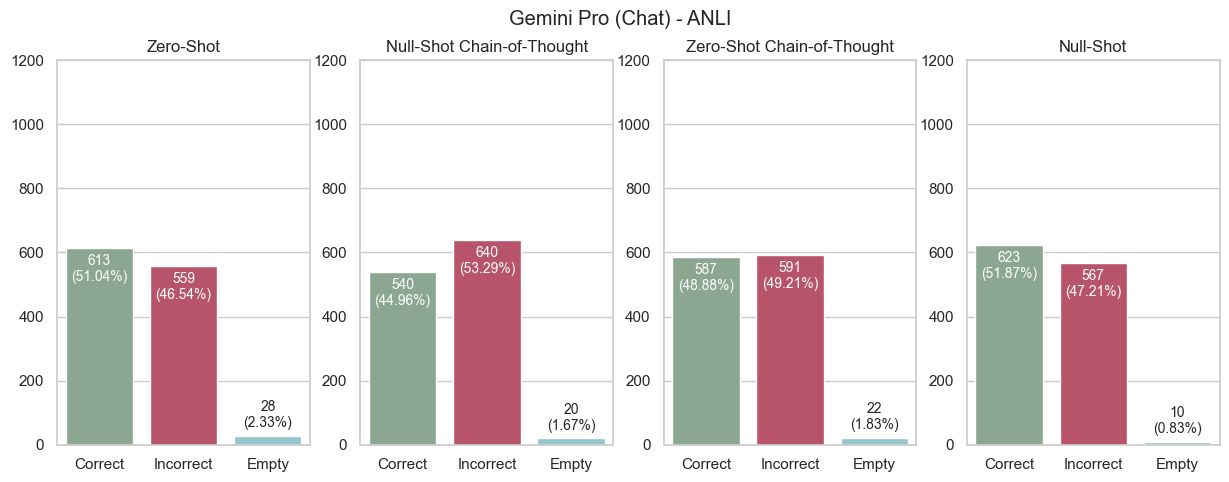

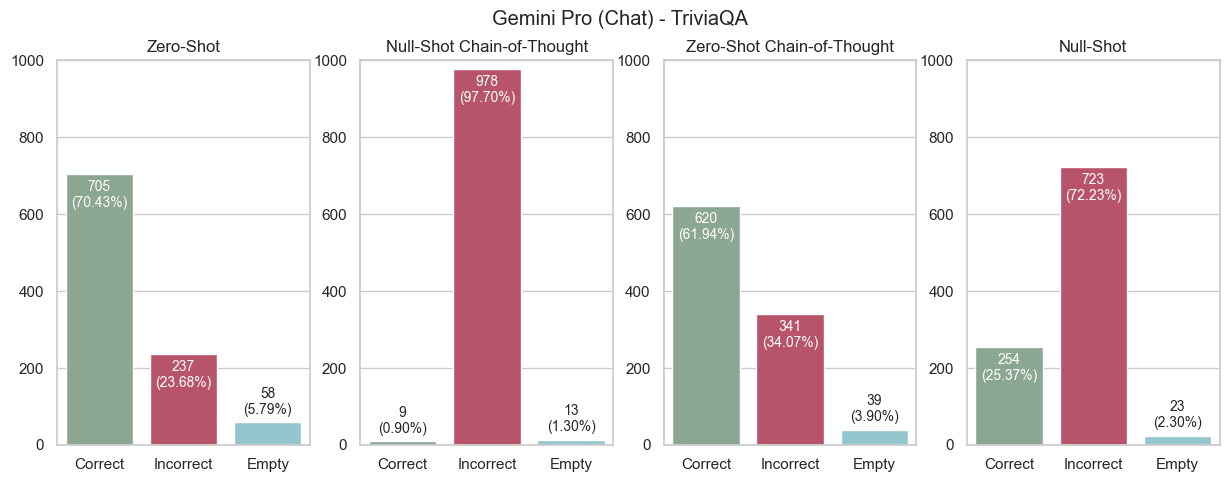

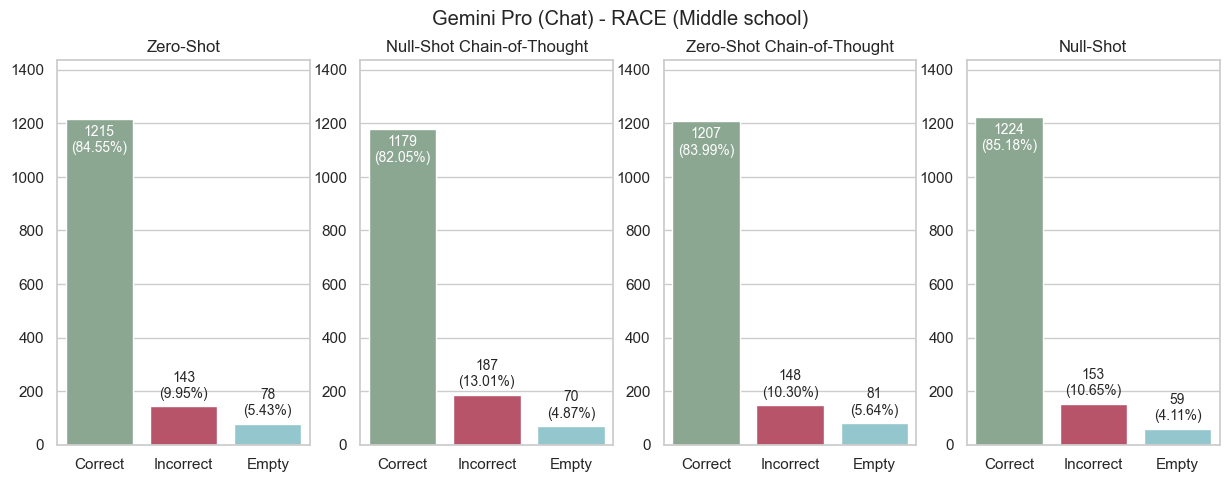

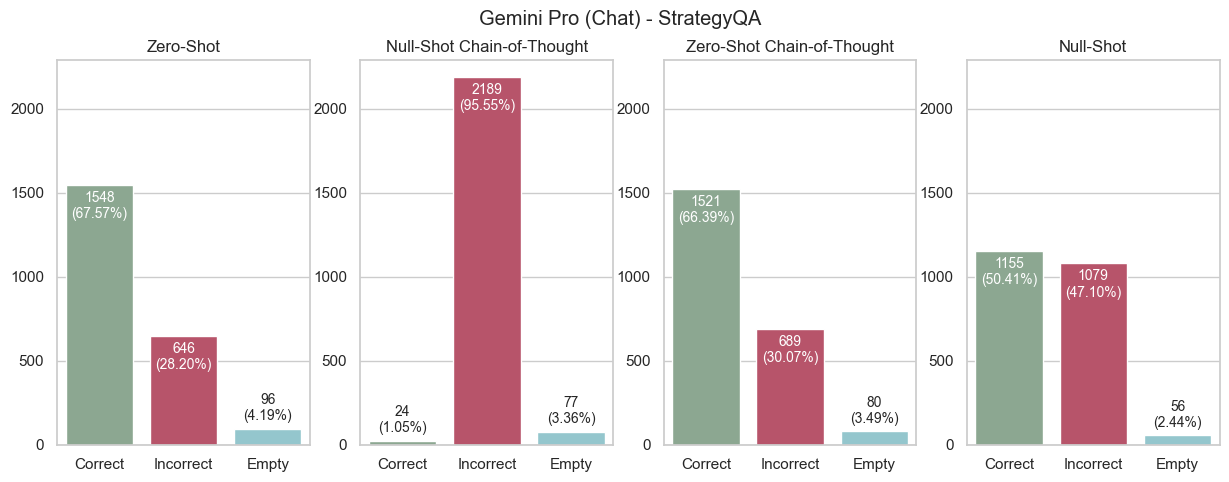

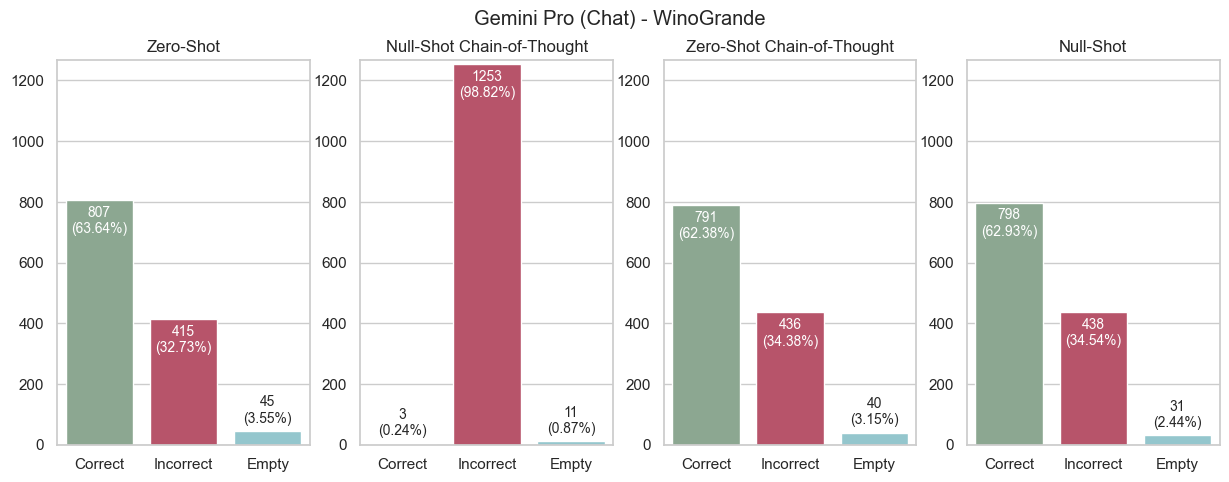

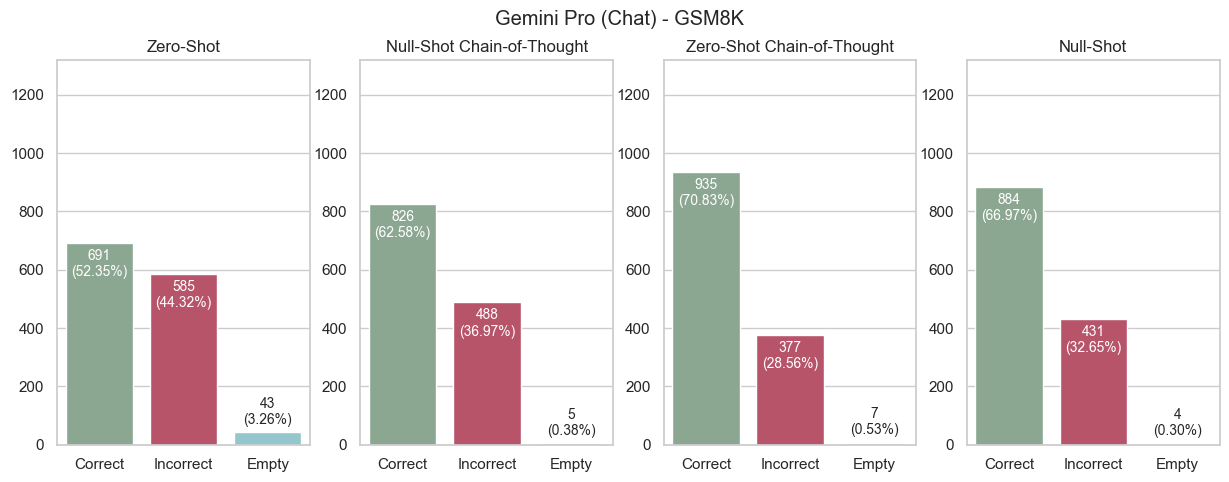

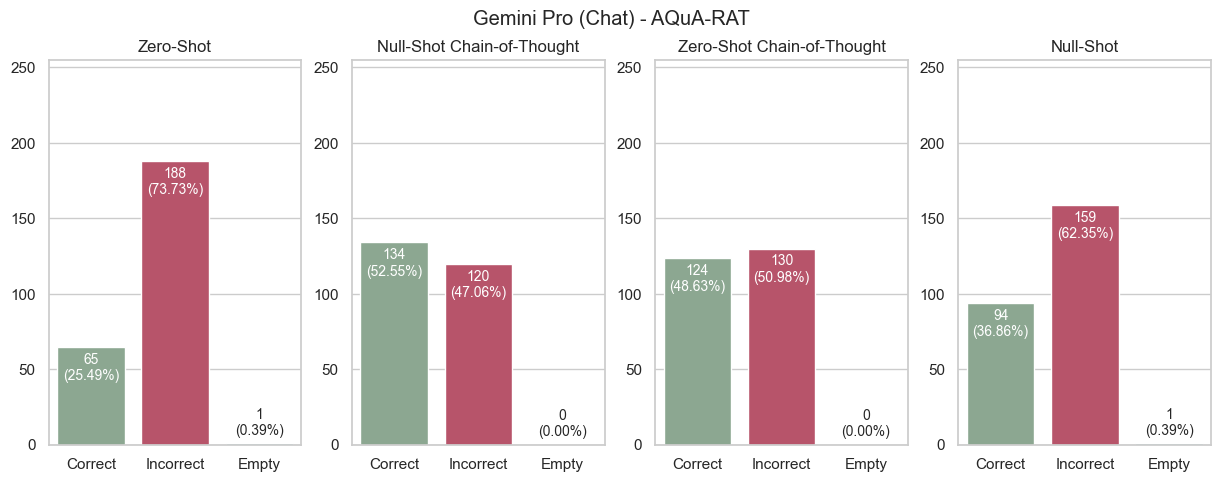

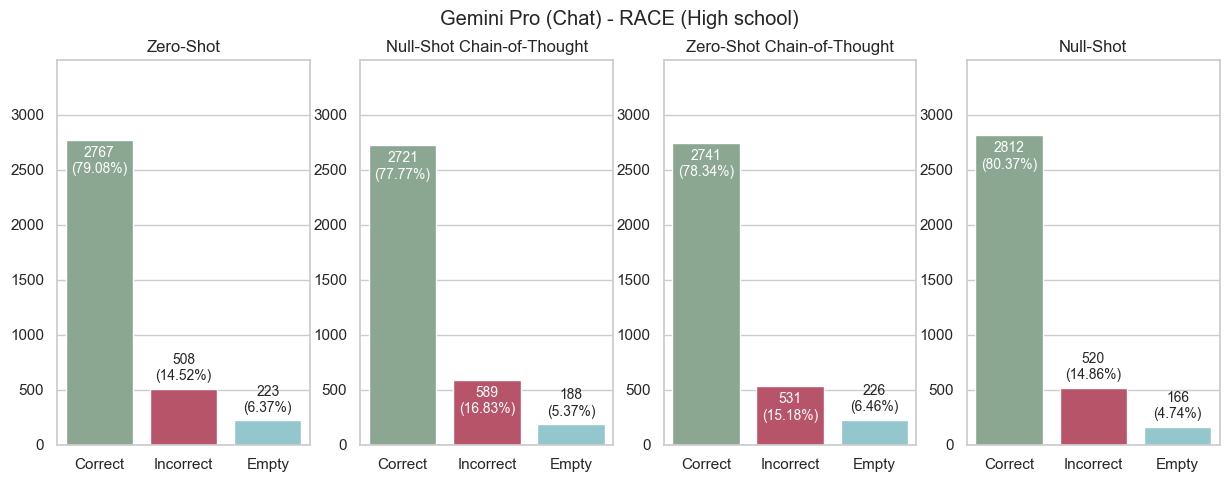

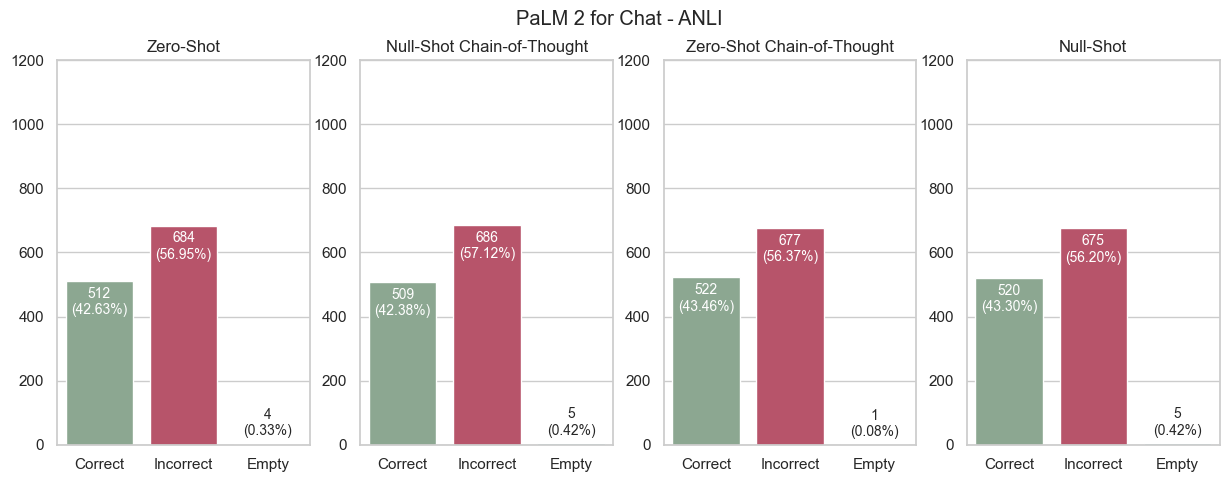

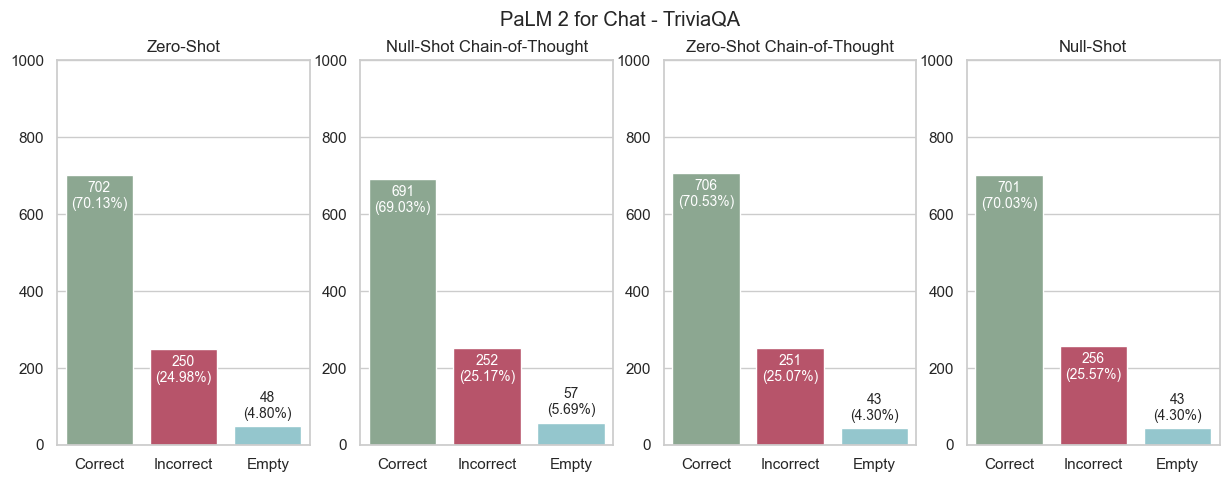

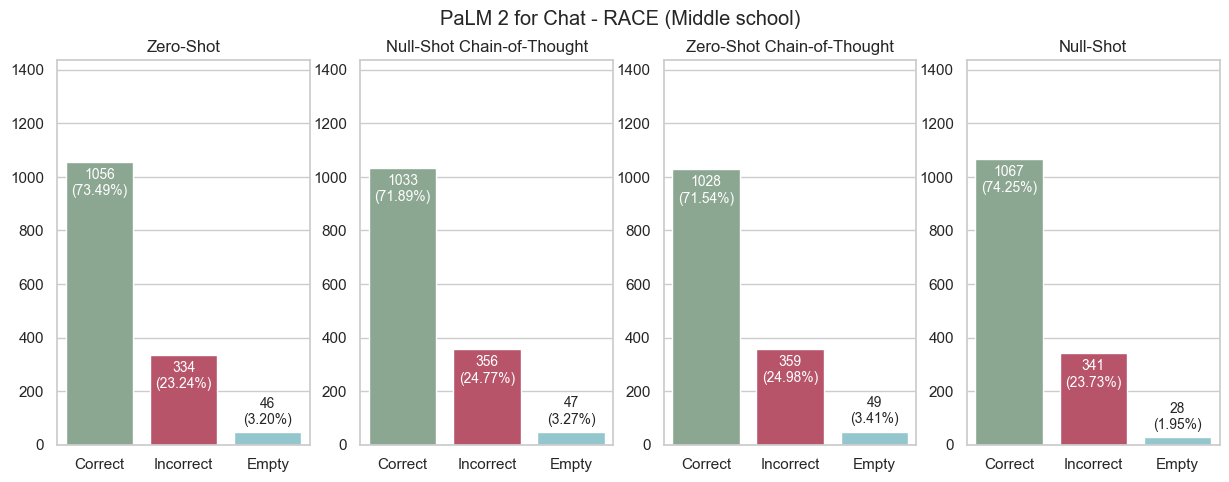

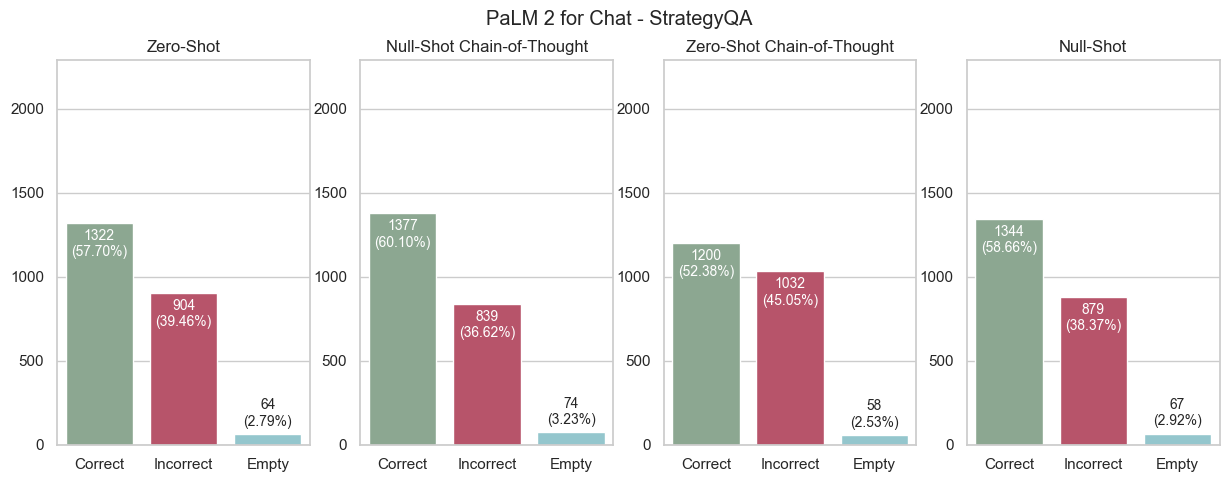

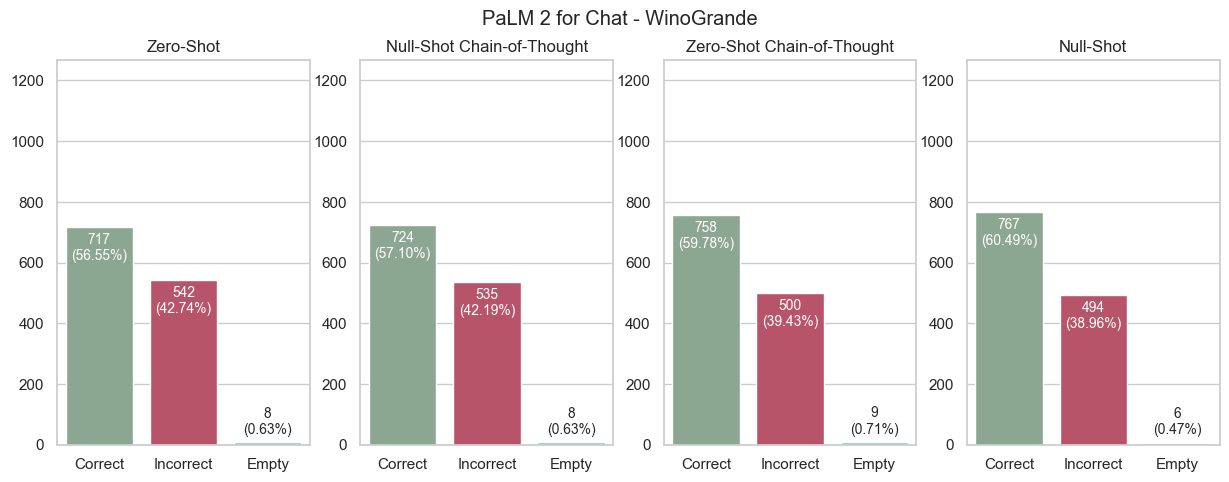

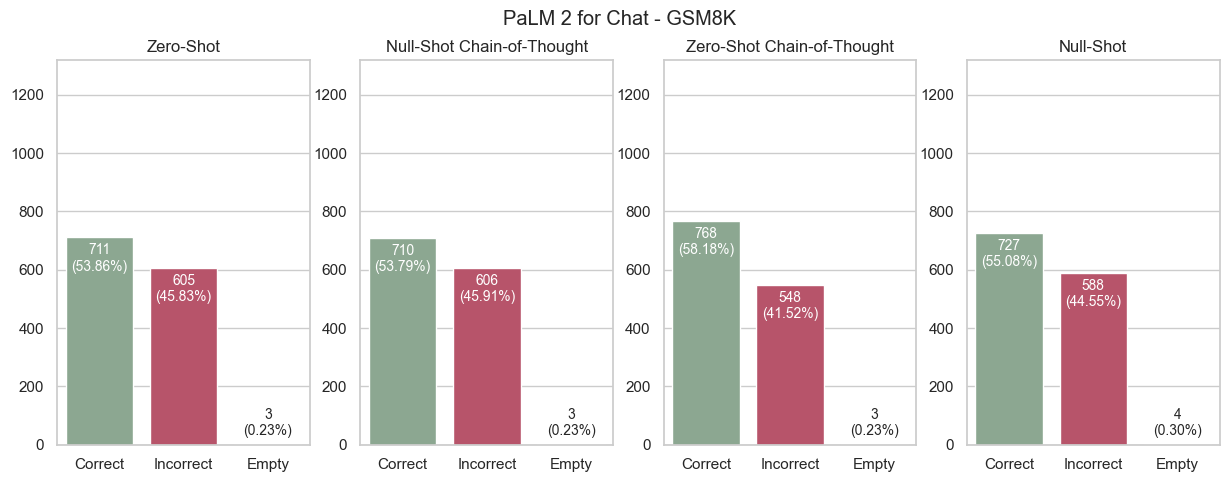

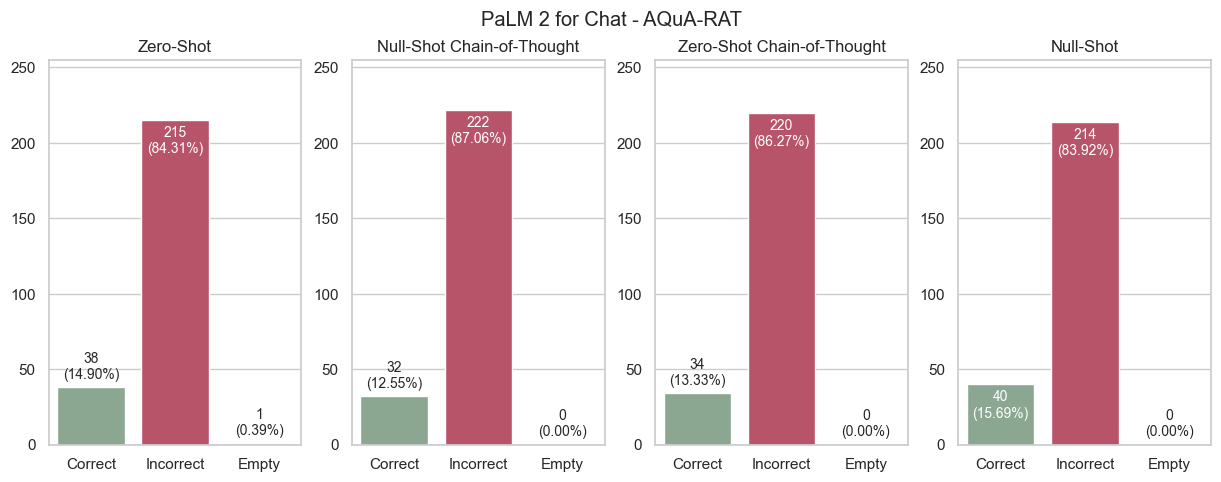

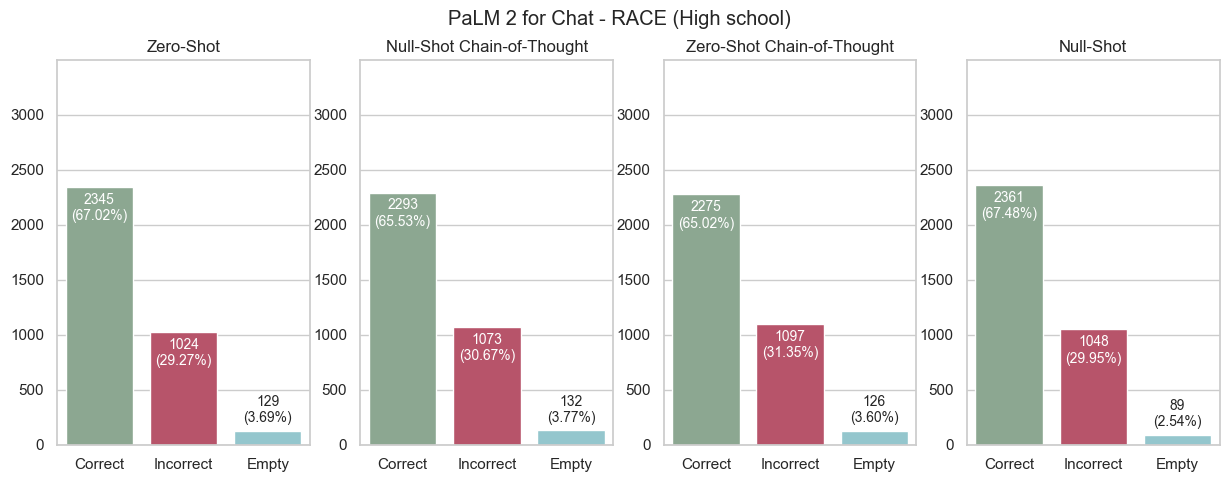

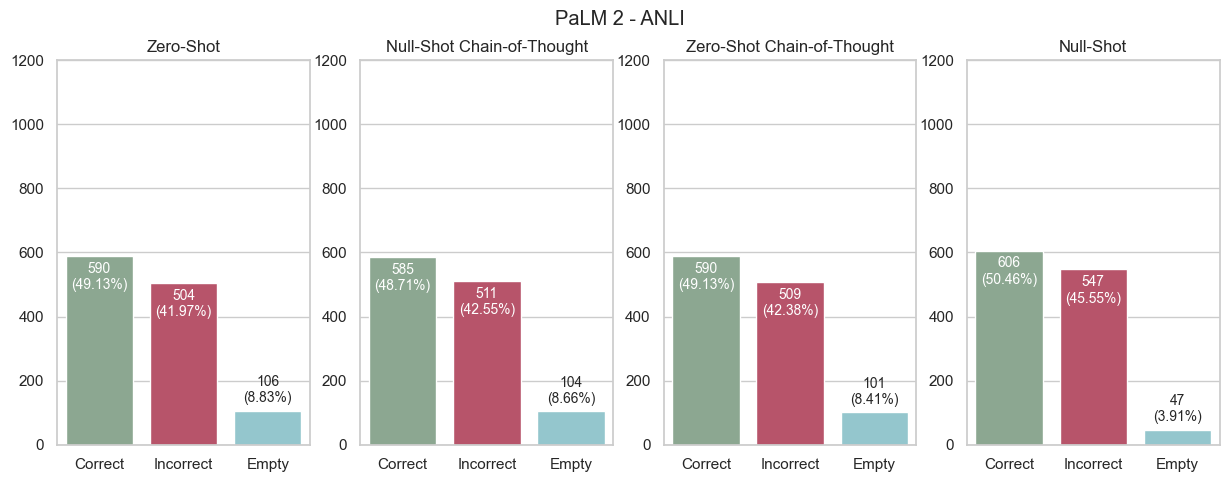

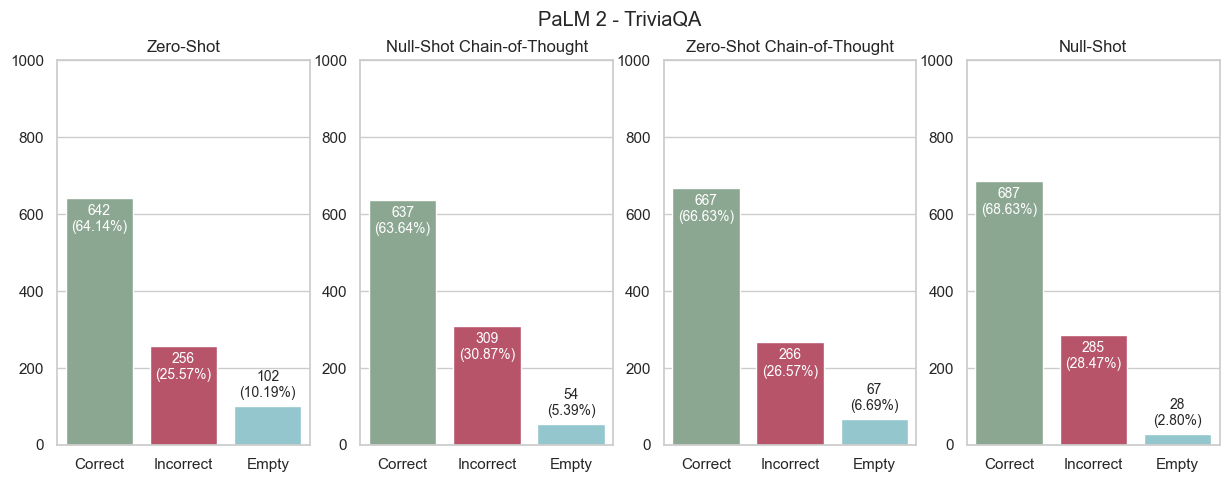

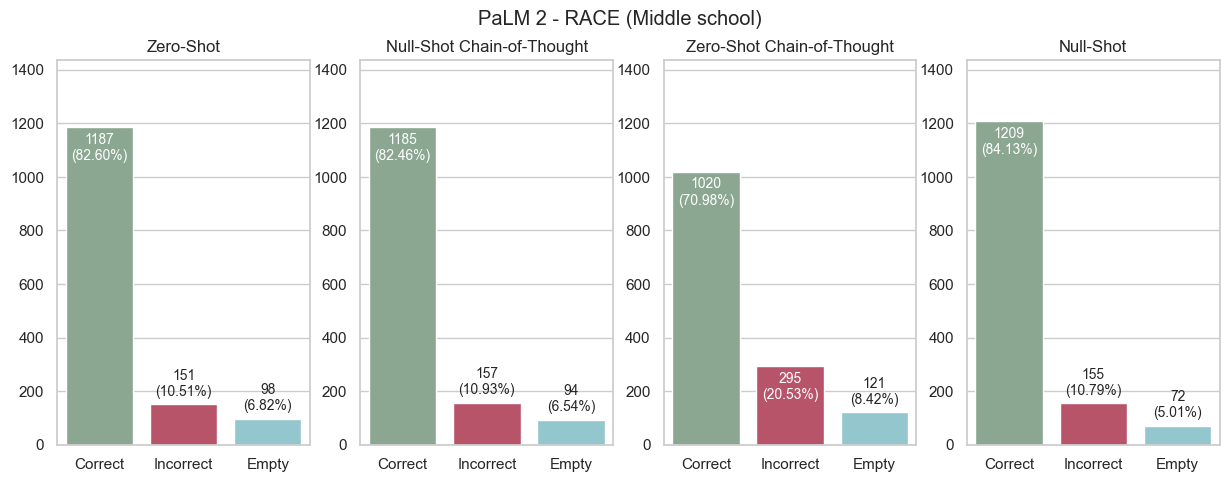

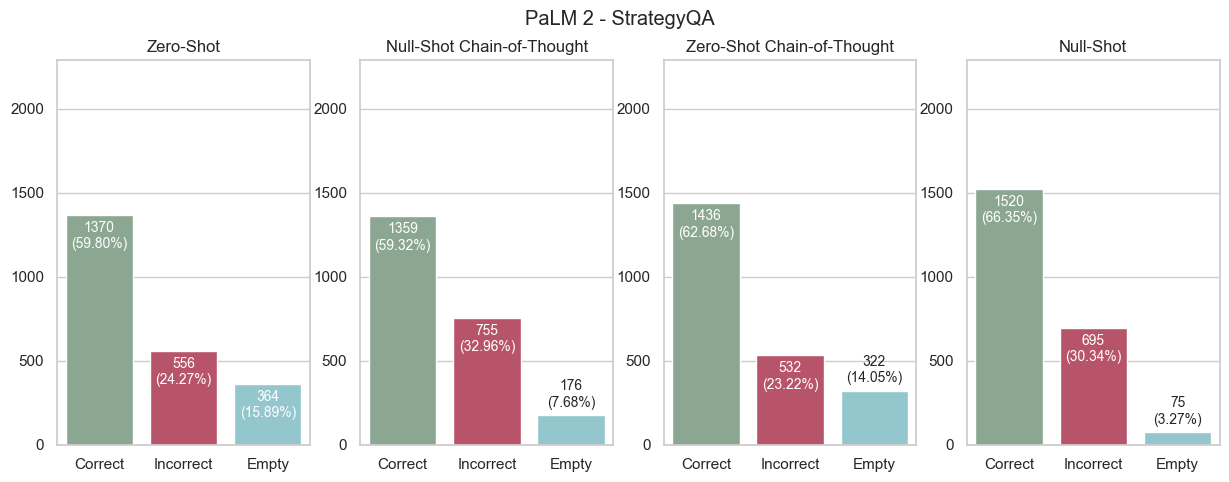

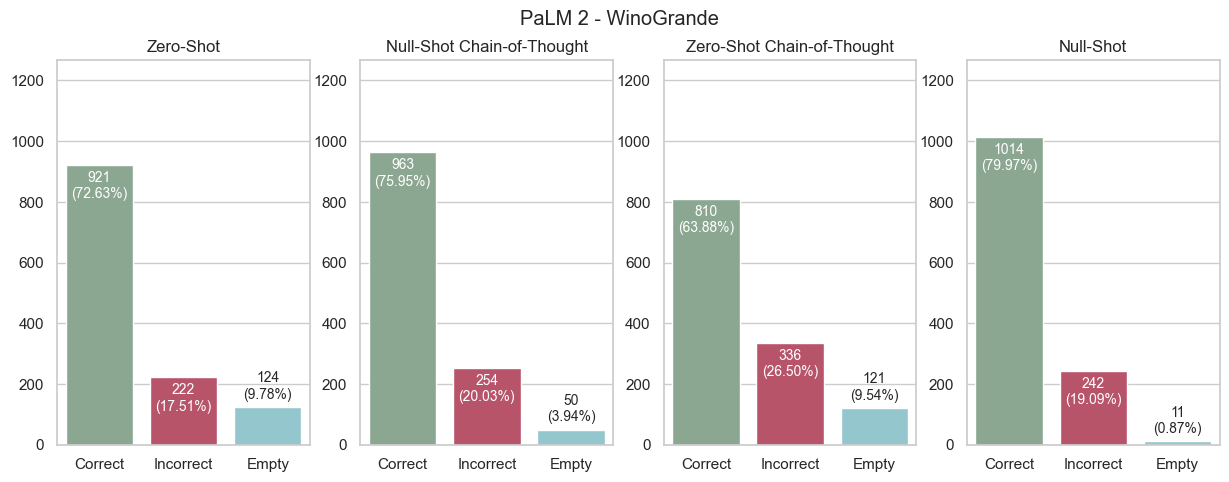

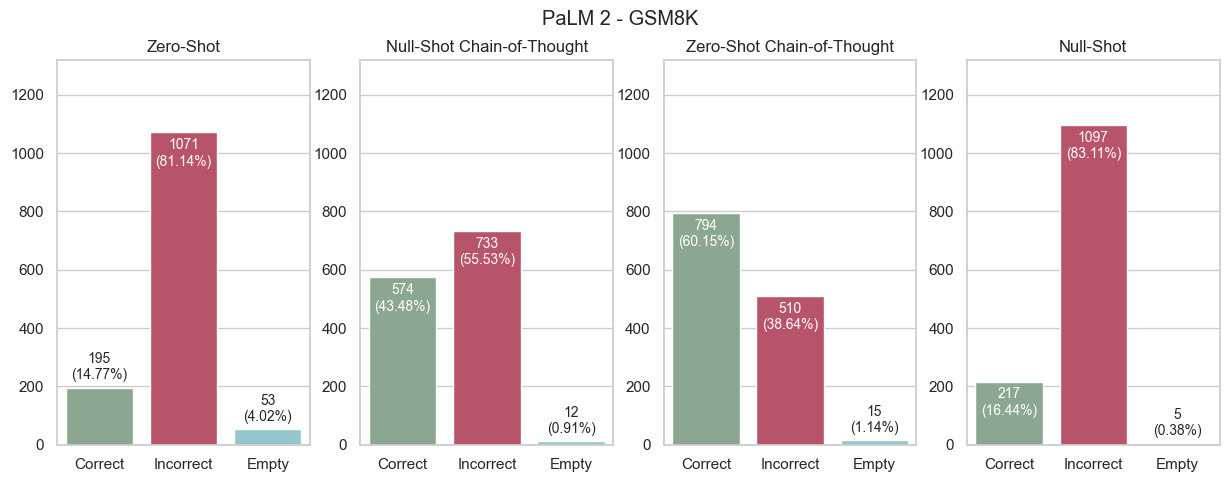

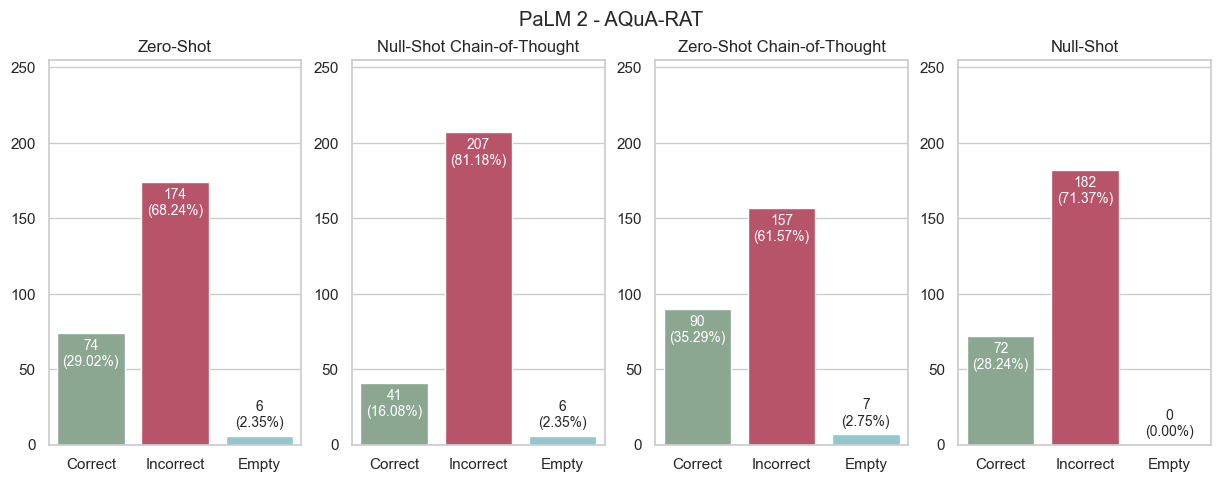

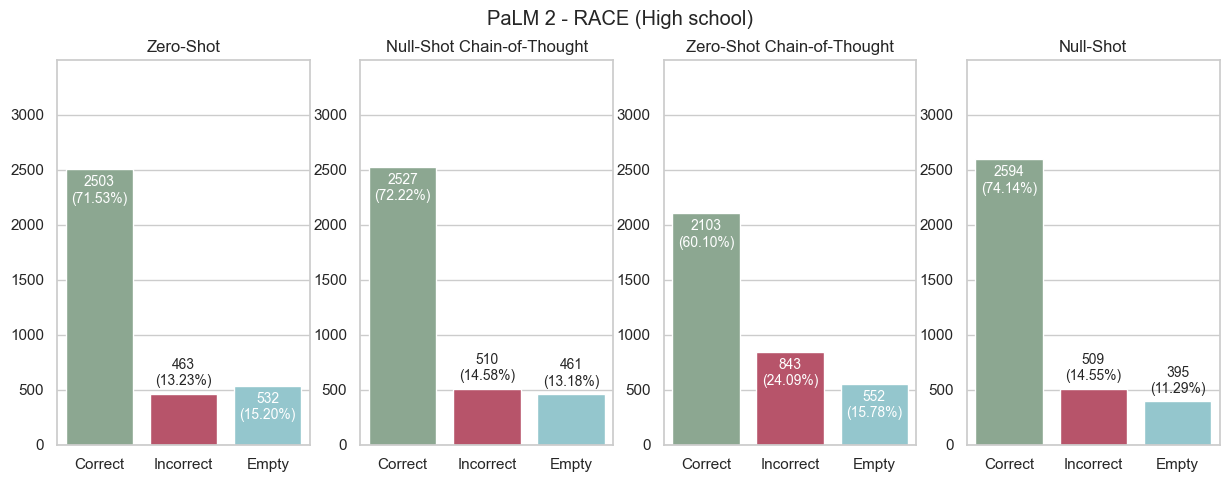

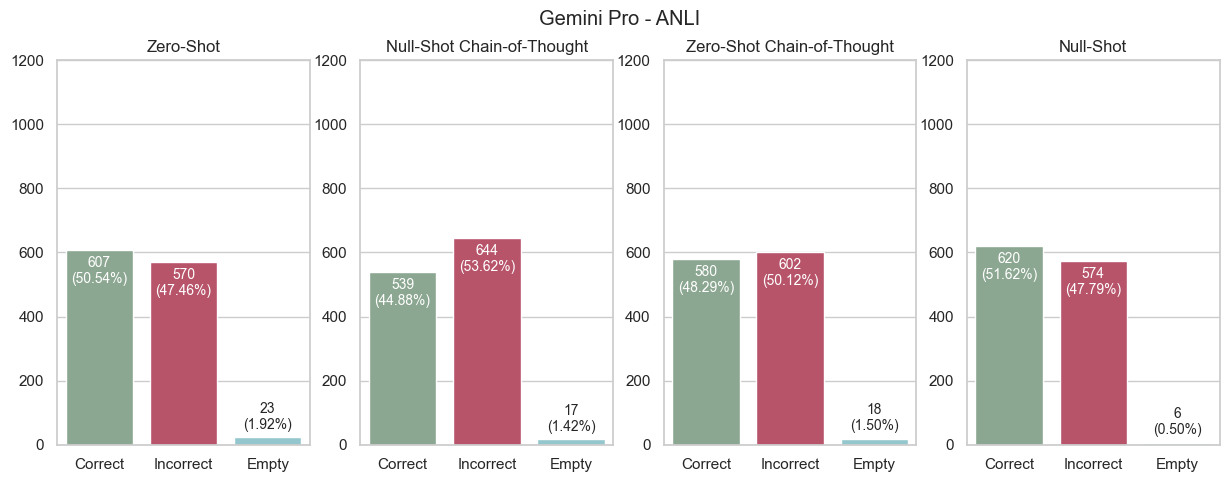

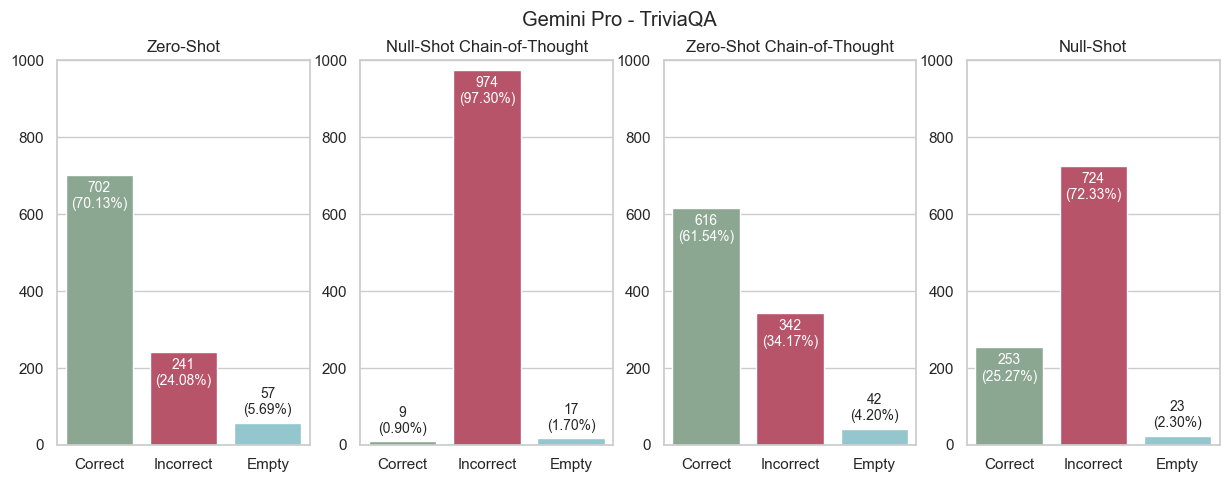

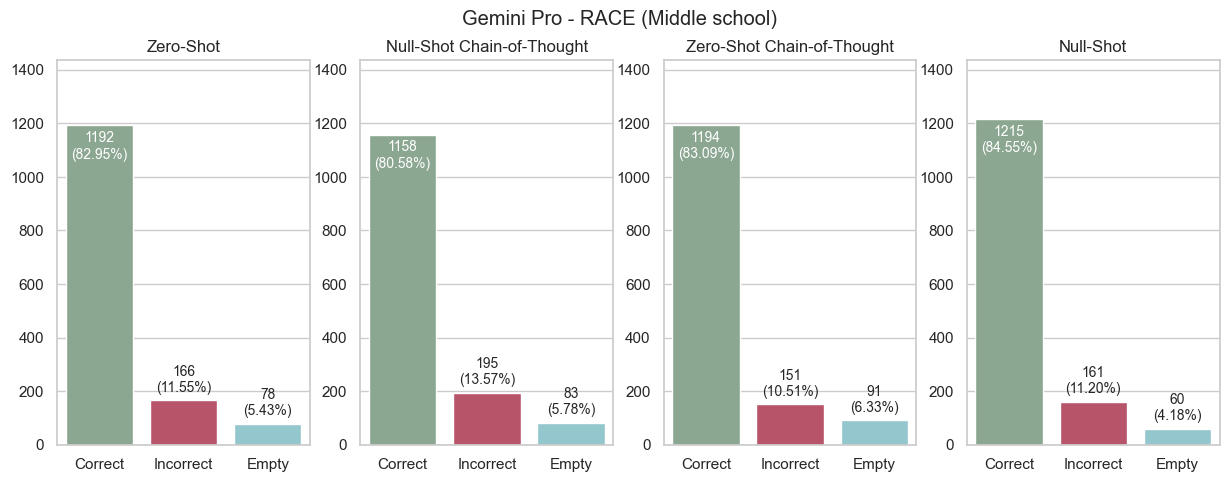

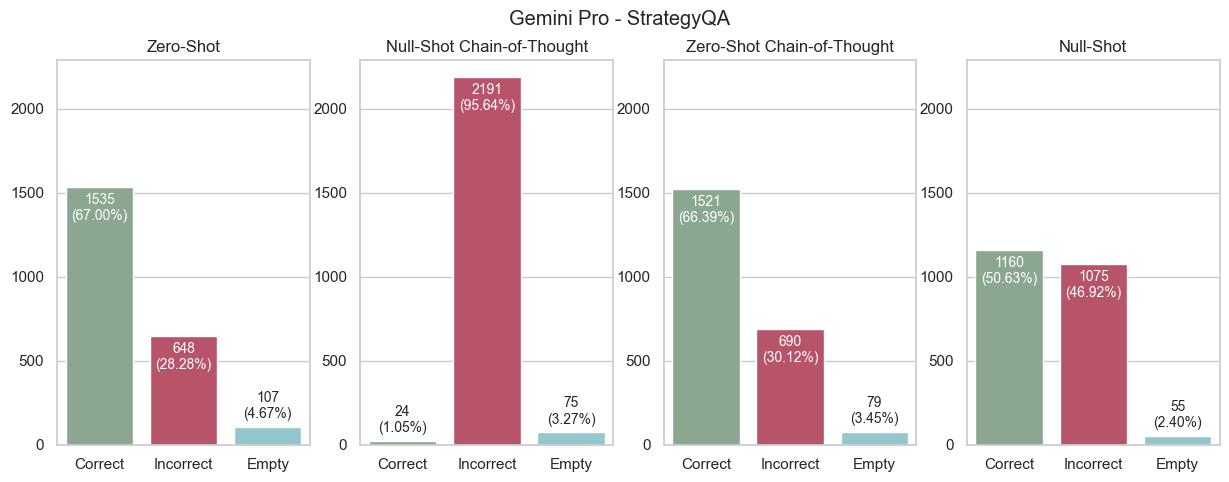

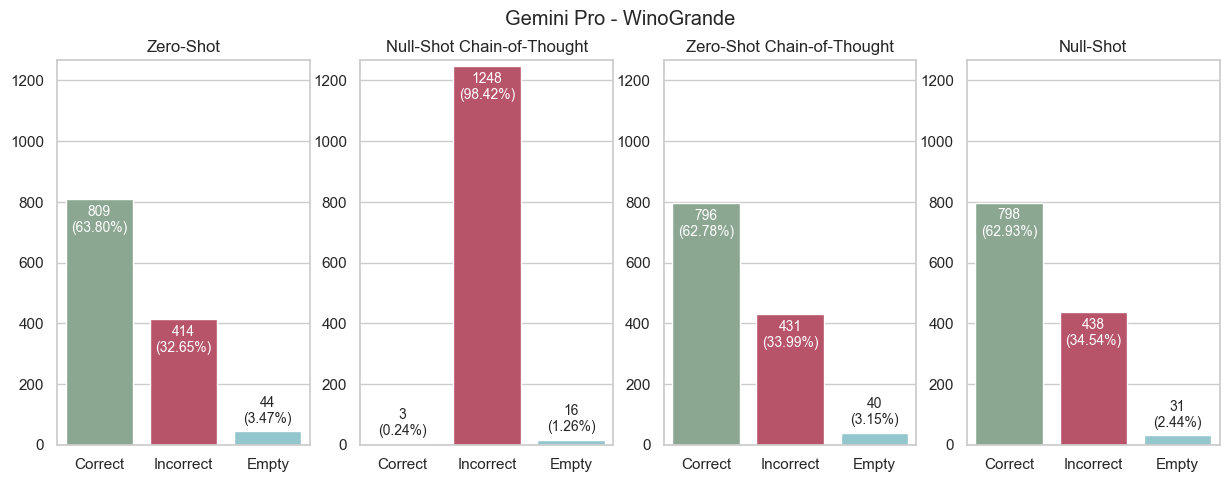

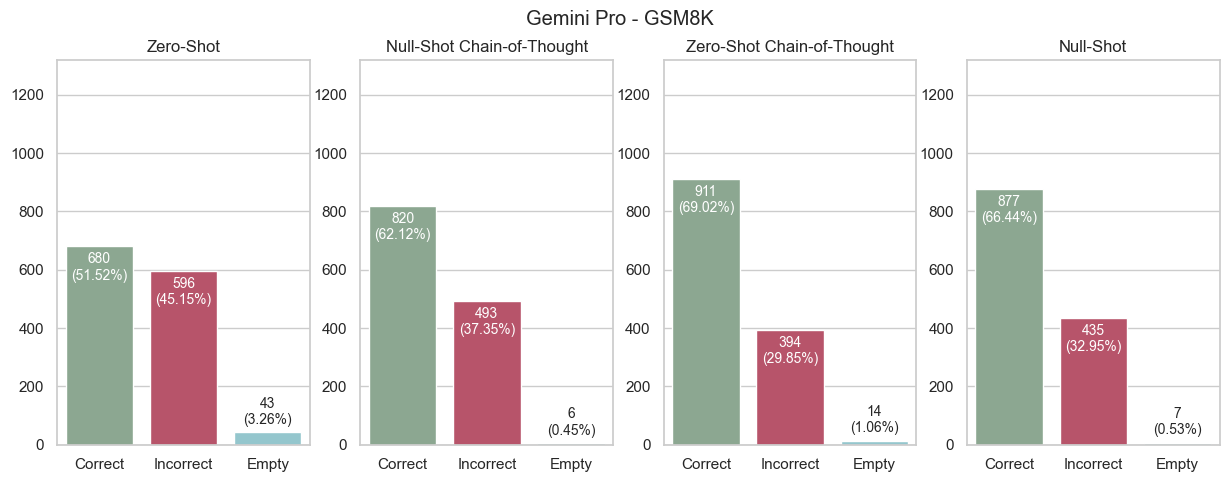

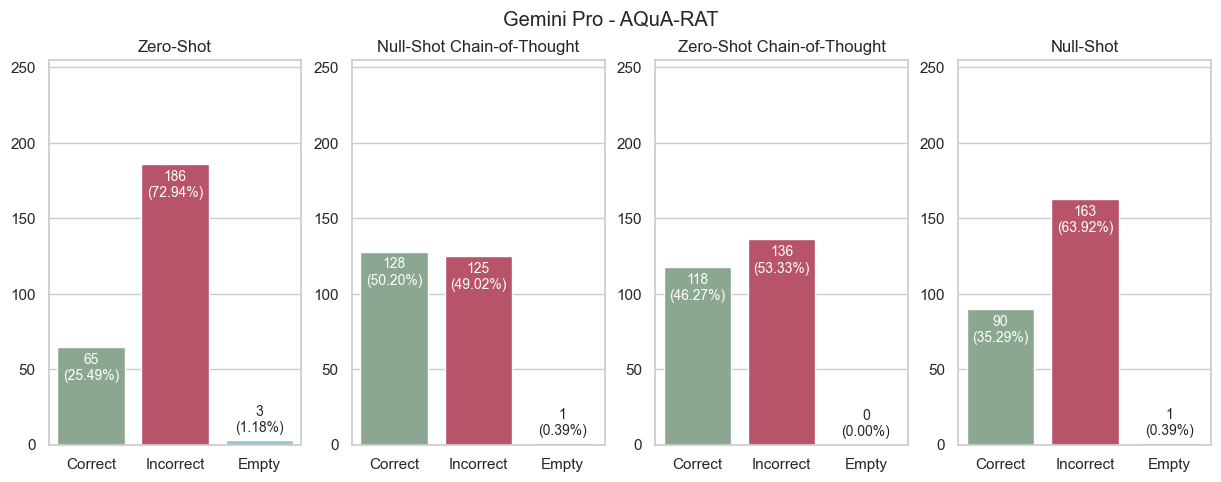

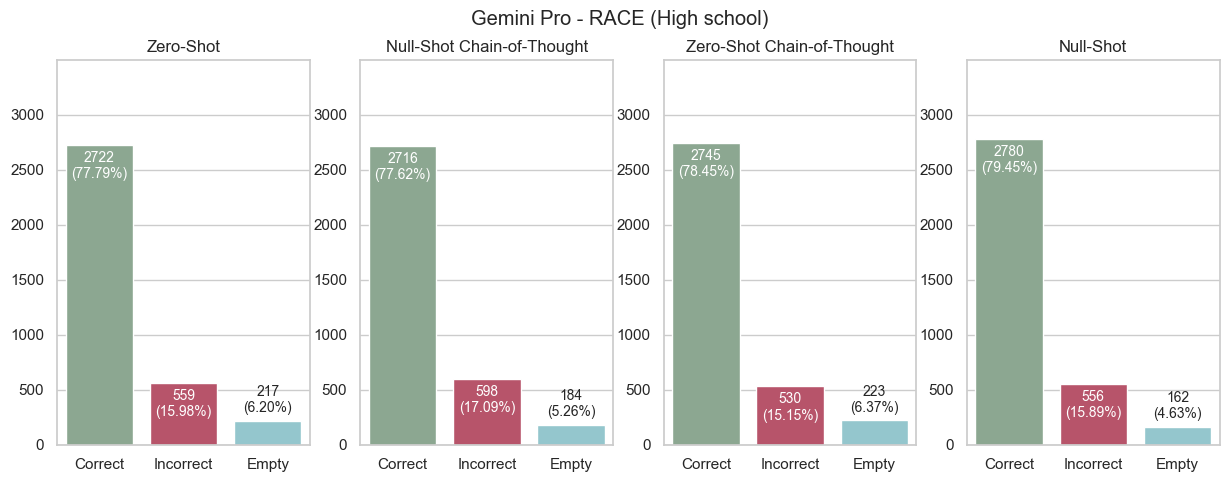

In [21]:
for model in plot_data:
    for task in plot_data[model]:
        fig, ax = plt.subplots(1, 4, figsize=(15, 5))

        for i, pe in enumerate(plot_data[model][task]):
            xs = plot_data[model][task][pe].keys()
            ys = plot_data[model][task][pe].values()

            sns.barplot(x=xs, y=ys, ax=ax[i], hue=colors, legend=False, palette=colors)

            ax[i].set_ylim(0, summarized_error_categories[model][task][pe][
                "total"])  # Set the y-axis limit to the total number of records in each task

            ax[i].set_title(pe_names[pe])

            for p in ax[i].patches:
                percentage = '{:.2f}%'.format(
                    100 * p.get_height() / summarized_error_categories[model][task][pe]["total"])

                # Nice formatting for annotations
                if p.get_height() > 0:
                    if p.get_height() / summarized_error_categories[model][task][pe]["total"] > 0.15:
                        ax[i].annotate(f"{int(p.get_height())}\n({percentage})",
                                       (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center',
                                       xytext=(0, -15), textcoords='offset points', fontsize=10, color="white")
                        continue

                ax[i].annotate(f"{int(p.get_height())}\n({percentage})",
                               (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center',
                               xytext=(0, 15), textcoords='offset points', fontsize=10)

        fig.suptitle(f"{model_names[model]} - {task_names[task]}")
        Path("error_analysis").mkdir(exist_ok=True)
        plt.savefig(f"error_analysis/{model}_{task}.png", bbox_inches='tight')
        plt.show()

In [22]:
plot_data_df = {
    "model": [],
    "task": [],
    "method": [],
    "Correct": [],
    "Incorrect": [],
    "Empty": []
}

for model in plot_data:
    for task in plot_data[model]:
        for method in plot_data[model][task]:
            plot_data_df["model"].append(model)
            plot_data_df["task"].append(task)
            plot_data_df["method"].append(method)
            plot_data_df["Correct"].append(plot_data[model][task][method]["Correct"])
            plot_data_df["Incorrect"].append(plot_data[model][task][method]["Incorrect"])
            plot_data_df["Empty"].append(plot_data[model][task][method]["Empty"])

plot_data_df = pd.DataFrame(plot_data_df)

In [23]:
plot_data_df.head()

,model,task,method,Correct,Incorrect,Empty
0,gemini-pro-chat,anli,zero-shot,613,559,28
1,gemini-pro-chat,anli,null-shot-cot,540,640,20
2,gemini-pro-chat,anli,zero-shot-cot,587,591,22
3,gemini-pro-chat,anli,null-shot,623,567,10
4,gemini-pro-chat,triviaqa,zero-shot,705,237,58


In [24]:
plot_data_df.to_csv("error_analysis.csv", index=False)